#### This custom kernel should have PyTorch and Huggingface already installed

## ReviewSummarizer
#### Goal:
Build a dashboard using the BERT and Pegasus Transformer Encoder/Decoder models to provide digestable analytics on a restaurants performance.

We scrap Yelp! reviews on an inputted restaurant name.
We pass each review into BERT to produce an associated rating column
We graph the distribution of high/low comments, giving the viewer an understanding of outlying observations and general trend regarding reviews
We pass the first and last quartile of reviews into Pegasus to produce the summarized reason why the 1st quartile gave such low reviews, and why the last quartile gave such nice reviews.
This tool is ment to help restaurants acquire a deep insight into the relationship with their audience, to understand the prevelance/extremity of certain complements and criticisms, along with quick pointers on how to fix the restaurant's most pressing issues/capture it's most successful

#### Note:
This will be written as an executable script with arguments for the input string representing the name and city of the restaurant on Yelp! trait.

### STEP 0: Args Setup

In [1]:
import sys
term = sys.argv[1]
location = sys.argv[2] ## Make this smarter later (what if city contains 'city, country'? etc.)

## Hardcoded values; Testing Purposes
testName = 'Lazeez Restaurant'
testLoc = 'Mississauga, ON'


### STEP 1: Scraping Pipeline with BeautifulSoup4

In [2]:
from bs4 import BeautifulSoup
import re
import requests 

##### 1.1 Defining Scrape Method

In [3]:
apiKey = 'gUZY4zxhCM6Hz-3_iyUFM6v1lqIYCQyV6mUdk8BseiNmmzD1SaDyqTDNpMLvKwuMbO9sD3YBKvt5gatpFhe8EPwQnMNMyhm0Z2bMQb9QAqEEUgRhGGRPz6GorllpZXYx' 
## Should I keep this private? LOL 

## Input: 
#### term: Name of restaurant
#### location: location of restaurant, comma seperated with city, province, country
#### index: if 0, will pick top search result when parsing Yelp! with API, else will pick index'th result
def searchYelp(term, location, index=0):

    endpoint = "https://api.yelp.com/v3/businesses/search"
    headers = {
        "Authorization": f"Bearer {apiKey}"
    }
    params = {
        'term':term,
        'location':location
    } 
    req = requests.get(endpoint, headers=headers, params=params)

    ## If response code successful (Code 200):
    if req.status_code == 200:
        businesses=req.json().get('businesses', [])

        
        for business in businesses:
            apiKey
            #print(f"Name: {business['name']}, Rating: {business['rating']}, URL: {business['url']}")
    
        ## Picking index'th search result as restaurant
        bparams = {
            'id' : businesses[0]['id']
        }
        b = {
            'source' : businesses[0],
            'link' : businesses[0]['url'],
            'id' : businesses[0]['id']
        }

        
        b['req'] = requests.get(b['link'], headers = headers, params = bparams)
        b['soup'] = BeautifulSoup(b['req'].text, 'html.parser')
        b['regex'] = re.compile('.*comment.*')  ## Using regex expression to find all classes that are comments on restaurant (to use for customer sentiment analysis)
        b['results'] = b['soup'].find_all('p', {'class':b['regex']})
        b['reviews'] = [result.text for result in b['results']]

        
        if req.status_code != 200:
            
            print(f"Error. Request denied with code: {req.status_code}.")
            return
            
        return b

        
        
    
        print(f"Error. Request denied with code: {req.status_code}.")

#### 1.2 Executing Scraping Method, Saving reviews in dict

In [4]:
reviews = searchYelp(testName, testLoc)['reviews']
print(reviews)
print('')
print(len(reviews))




['Chicken Shawarma Platter and Greek SaladThis was FANTASTIC! The Shawarma was outstanding and filling and the salad was outstanding! Will definitely be going back', "Four words; they can do betterComing here from living in an Arab country for most of my life, the chicken shawarma they make here is very disappointing. But I know a lot of people who live this place, I just don't get the hype. I guess everyone's taste buds are just different idk", '10/10. Fries have flour on them I think tho, so not GF friendly, but yum. The guys were nice when I went.', "Been here a few times and always get lazeez on the rocks. I've had it with rice, fries, and potatoes but I think that my favourite combination would be half fries and half rice. Potatoes are $1 extra and salads are $3 extra. Their sauces are really good! Wish they put a little bit of veggies in their regular meals, would make the meal more refreshing. Proportions are pretty large/decent size. The large was $8.99 and the regular was $6.9

In [5]:
import pandas as pd

reviews = pd.DataFrame({
    
    'text' : list(reviews), 
    'score' : list(range(len(reviews))) ## temporary values
    
})

### STEP 2: Scoring w/ BERT, HuggingFace Transformers Library

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [7]:
bertTokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
bertModel = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [8]:
reviews['score'] = [int(torch.argmax(bertModel(bertTokenizer.encode(review, return_tensors='pt')).logits)) for review in reviews['text']] ## class rating
reviews ## ratings are from 0-5

,text,score
0,Chicken Shawarma Platter and Greek SaladThis w...,4
1,Four words; they can do betterComing here from...,2
2,"10/10. Fries have flour on them I think tho, s...",4
3,Been here a few times and always get lazeez on...,3
4,Exam season in full swing and I've pretty much...,3
5,Cheap but you get what you pay for.I tried the...,2
6,I like this location. The young guy who works ...,3
7,I was never really a fan of shawarmas and didn...,2
8,Staff is very rude and I've noticed this at mo...,1
9,Lazeez offers a variety of grilled Middle East...,3


### STEP 3: Distribution Plot w/ Seaborn, EXPAND THIS FURTHER WITH MORE ANALYTICS?

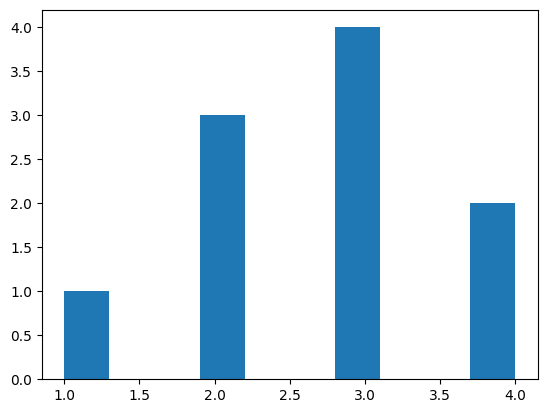

In [9]:
import matplotlib.pyplot as plt 

plot = plt.hist(reviews['score'])

In [10]:
q1=reviews[list(reviews['score'] <= reviews['score'].quantile(0.25))]
q3=reviews[list(reviews['score'] >= reviews['score'].quantile(0.75))]

print(q1)
print('')
print(q3)

                                                text  score
1  Four words; they can do betterComing here from...      2
5  Cheap but you get what you pay for.I tried the...      2
7  I was never really a fan of shawarmas and didn...      2
8  Staff is very rude and I've noticed this at mo...      1

                                                text  score
0  Chicken Shawarma Platter and Greek SaladThis w...      4
2  10/10. Fries have flour on them I think tho, s...      4
3  Been here a few times and always get lazeez on...      3
4  Exam season in full swing and I've pretty much...      3
6  I like this location. The young guy who works ...      3
9  Lazeez offers a variety of grilled Middle East...      3


In [20]:
def passage(lstr):

    cur = lstr[0]

    for string in lstr[1:]:
        cur = cur + ' ' + string

    return cur

badTexts = list(q1['text'])
goodTexts = list(q3['text'])

In [21]:
badTexts

["Four words; they can do betterComing here from living in an Arab country for most of my life, the chicken shawarma they make here is very disappointing. But I know a lot of people who live this place, I just don't get the hype. I guess everyone's taste buds are just different idk",
 "Cheap but you get what you pay for.I tried the lazeez on the sticks. (Basically lazeez on the rocks with fries) It was pretty cheap, only 8.99 for a large and a little more than 10 after tax.Overall it was kinda boring. Yes, it is meat on fries with sauce. It was pretty decent at the beginning, but then you realize it is just a bucket of fries and meat, and the pieces of meat are lower quality when compared with any of the shawarma places in the surrounding area (shawarma royale, shawerma plus, mozy) I got the medium heat, but found that pretty spicy. I usually get hot sauce at mozy and the otherwise, but the level 3 medium felt flaming.I'll probably try their shawarma some other time to compare between 

In [22]:
goodTexts

['Chicken Shawarma Platter and Greek SaladThis was FANTASTIC! The Shawarma was outstanding and filling and the salad was outstanding! Will definitely be going back',
 '10/10. Fries have flour on them I think tho, so not GF friendly, but yum. The guys were nice when I went.',
 "Been here a few times and always get lazeez on the rocks. I've had it with rice, fries, and potatoes but I think that my favourite combination would be half fries and half rice. Potatoes are $1 extra and salads are $3 extra. Their sauces are really good! Wish they put a little bit of veggies in their regular meals, would make the meal more refreshing. Proportions are pretty large/decent size. The large was $8.99 and the regular was $6.99zStaff were okay, could tell they were high, saw one holding cigarettes (with plastic gloves on), put them away, then proceeded to prepare food..",
 "Exam season in full swing and I've pretty much lost the little motivation I had to cook my own meals, so I've been resorting to get

### STEP 4: Summarization of first, last quantile using Pegasus, quantifying error in summarization 
(how representative is this summarization of all the comments in this quartile?)

##### 4.1 Load Models

In [12]:
## Install PyTorch, HuggingFace Transformers Library, SentencePiece
# !conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# !conda install -c huggingface transformers
# !conda install -c conda-forge sentencepiece
import sys
#!{sys.executable} -m pip install git+https://github.com/huggingface/transformers

In [13]:
## Import Dependencies from Transformers
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

##### 4.2: Instantiate, Encode + Decode Summarization

In [14]:
## Initialize Tokenizer
pegTokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
## Initialize Model
pegModel = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
badSummary = [pegTokenizer.decode(pegModel.generate(**pegTokenizer(badText, truncation=True, padding='longest', return_tensors='pt'))[0]) for badText in badTexts]
goodSummary = [pegTokenizer.decode(pegModel.generate(**pegTokenizer(goodText, truncation=True, padding='longest', return_tensors='pt'))[0]) for goodText in goodTexts]



In [37]:
for i in range(len(badSummary)):
    badSummary[i] = badSummary[i][5:-4]
for i in range(len(goodSummary)):
    goodSummary[i] = goodSummary[i][5:-4]

In [38]:
badSummary

['What do you think of the shawarma at this restaurant in the West End?',
 "I've been to this place before and it's pretty good.",
 "Lazeez is one of the best shawarma places I've ever been to.",
 "I'm writing to let you all know that I'm going to be leaving a review of my local McDonald's."]

In [39]:
goodSummary

['The food was delicious and the service was excellent.',
 "I've been to this place before and it's the best fries I've had.",
 "I've been to this place a few times and always get lazeez on the rocks.",
 "It's been a while since I've been to Lazeez.",
 "I've been to this place before and it's pretty good.",
 "If you're a fan of shawarma then Lazeez is the place for you."]

In [40]:
badSummaryFinal = pegTokenizer.decode(pegModel.generate(**pegTokenizer(badSummary, truncation=True, padding='longest', return_tensors='pt'))[0])
goodSummaryFinal = pegTokenizer.decode(pegModel.generate(**pegTokenizer(goodSummary, truncation=True, padding='longest', return_tensors='pt'))[0])

In [41]:
badSummaryFinal

"<pad>shawarma restaurant in London's West End - what do you think of it?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

In [42]:
goodSummaryFinal

'<pad>The food was delicious and the service was excellent.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'